# 目录

# 1 分类型变量
 
-  1.1 转换-分类型变量 重分组

-  1.2 转换-分类型变量 one-hot编码  


# 2 连续型变量

- 2.1 衍生-连续型变量 非线性衍生
     
- 2.2 衍生-连续型变量 简单组合

- 2.3 转换-连续型变量 正态转换
 - 2.3.1 y值正态变换
 - 2.3.2 连续型特征正态变换

- 2.4 转换-连续型变量 无量纲化转换

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

import matplotlib.pyplot as plt
%matplotlib inline


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 准备工作

In [ ]:
# 引入'2-数据清洗'处理
%run 2-数据清洗.ipynb

In [79]:
train.head()
train.info()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450.0,2,4.0,Lvl,4,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600.0,2,4.0,Lvl,4,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250.0,2,3.0,Lvl,4,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550.0,2,3.0,Lvl,4,Corner,...,0,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260.0,2,3.0,Lvl,4,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000.0


<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   object 
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1458 non-null   float64
 4   LotArea        1458 non-null   float64
 5   Street         1458 non-null   int64  
 6   LotShape       1458 non-null   float64
 7   LandContour    1458 non-null   object 
 8   Utilities      1458 non-null   int64  
 9   LotConfig      1458 non-null   object 
 10  LandSlope      1458 non-null   int64  
 11  Neighborhood   1458 non-null   object 
 12  Condition1     1458 non-null   object 
 13  Condition2     1458 non-null   object 
 14  BldgType       1458 non-null   object 
 15  HouseStyle     1458 non-null   object 
 16  OverallQual    1458 non-null   int64  
 17  OverallCond    1458 non-null   float64
 18  YearBuilt    

In [80]:
# 类别性变量区分度计算
def anova(train, categorical, y):
    anv = pd.DataFrame(index=categorical)
    anv['feature'] = categorical
    pvals = []
    for c in categorical:
        samples = []
        for cls in train[c].dropna().unique():
            s = train[train[c] == cls][y].values
            samples.append(s)  # 某特征下不同取值对应的房价组合形成二维列表
        pval = stats.f_oneway(*samples)[1]  # 一元方差分析得到 F，P，要的是 P，P越小，对方差的影响越大。
        pvals.append(pval)
    anv['pval'] = pvals
    anv['disparity'] = np.log(20*1./anv['pval'].values)/np.log(20)  # 区分度
    return anv.sort_values('pval')

cate_feature = [column for column in train.columns if train.dtypes[column] == 'object'] # 类型变量集合
y = 'SalePrice'
corr_cate = anova(train, cate_feature, y)

In [81]:
cate_feature

['MSSubClass',
 'MSZoning',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'YearBuilt',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'BsmtQual',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [82]:
# 统计变量的主要信息
train_ana = pd.DataFrame()

# 加入变量类型
train_ana['feature_type'] = train.dtypes

# 加入每个类别性变量的取值个数
train_ana['cate_cnt'] = train.apply(lambda x : x.nunique())

# 加入连续性变量相关度
numeric_cols = train.select_dtypes(include = ['int64', 'float64']).columns
train_ana['conti_corr'] = train[numeric_cols].corr()['SalePrice']

# 加入类别性变量区分度
train_ana['cate_corr'] = corr_cate['disparity']

# train_ana.sort_values(by = ['feature_type', 'conti_corr', 'cate_corr'], ascending=False)

# 1 分类型变量

In [83]:
train_ana.loc[train_ana.feature_type=='object', ].sort_values('cate_cnt', ascending=False)

,feature_type,cate_cnt,conti_corr,cate_corr
GarageYrBlt,object,146,NaN,65.625724
YearBuilt,object,112,NaN,93.575207
Neighborhood,object,25,NaN,185.462820
Exterior2nd,object,16,NaN,36.843009
Exterior1st,object,15,NaN,38.513217
MSSubClass,object,15,NaN,65.931200
MoSold,object,12,NaN,1.283750
Condition1,object,9,NaN,7.082620
SaleType,object,9,NaN,35.825456
Condition2,object,8,NaN,2.690296


## 1.1 转换-分类型变量 重分组

In [84]:
neighborhood_order = train.groupby('Neighborhood')['SalePrice'].median().sort_values().index
neighborhood_order

Index(['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards', 'BrkSide',
       'Sawyer', 'Blueste', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel', 'SawyerW',
       'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor',
       'Veenker', 'Somerst', 'Timber', 'StoneBr', 'NoRidge', 'NridgHt'],
      dtype='object', name='Neighborhood')

<Figure size 2400x600 with 0 Axes>

<Axes: xlabel='Neighborhood', ylabel='SalePrice'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'MeadowV'),
  Text(1, 0, 'IDOTRR'),
  Text(2, 0, 'BrDale'),
  Text(3, 0, 'OldTown'),
  Text(4, 0, 'Edwards'),
  Text(5, 0, 'BrkSide'),
  Text(6, 0, 'Sawyer'),
  Text(7, 0, 'Blueste'),
  Text(8, 0, 'SWISU'),
  Text(9, 0, 'NAmes'),
  Text(10, 0, 'NPkVill'),
  Text(11, 0, 'Mitchel'),
  Text(12, 0, 'SawyerW'),
  Text(13, 0, 'Gilbert'),
  Text(14, 0, 'NWAmes'),
  Text(15, 0, 'Blmngtn'),
  Text(16, 0, 'CollgCr'),
  Text(17, 0, 'ClearCr'),
  Text(18, 0, 'Crawfor'),
  Text(19, 0, 'Veenker'),
  Text(20, 0, 'Somerst'),
  Text(21, 0, 'Timber'),
  Text(22, 0, 'StoneBr'),
  Text(23, 0, 'NoRidge'),
  Text(24, 0, 'NridgHt')])

<Figure size 2400x600 with 0 Axes>

<Axes: xlabel='Neighborhood', ylabel='count'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'MeadowV'),
  Text(1, 0, 'IDOTRR'),
  Text(2, 0, 'BrDale'),
  Text(3, 0, 'OldTown'),
  Text(4, 0, 'Edwards'),
  Text(5, 0, 'BrkSide'),
  Text(6, 0, 'Sawyer'),
  Text(7, 0, 'Blueste'),
  Text(8, 0, 'SWISU'),
  Text(9, 0, 'NAmes'),
  Text(10, 0, 'NPkVill'),
  Text(11, 0, 'Mitchel'),
  Text(12, 0, 'SawyerW'),
  Text(13, 0, 'Gilbert'),
  Text(14, 0, 'NWAmes'),
  Text(15, 0, 'Blmngtn'),
  Text(16, 0, 'CollgCr'),
  Text(17, 0, 'ClearCr'),
  Text(18, 0, 'Crawfor'),
  Text(19, 0, 'Veenker'),
  Text(20, 0, 'Somerst'),
  Text(21, 0, 'Timber'),
  Text(22, 0, 'StoneBr'),
  Text(23, 0, 'NoRidge'),
  Text(24, 0, 'NridgHt')])

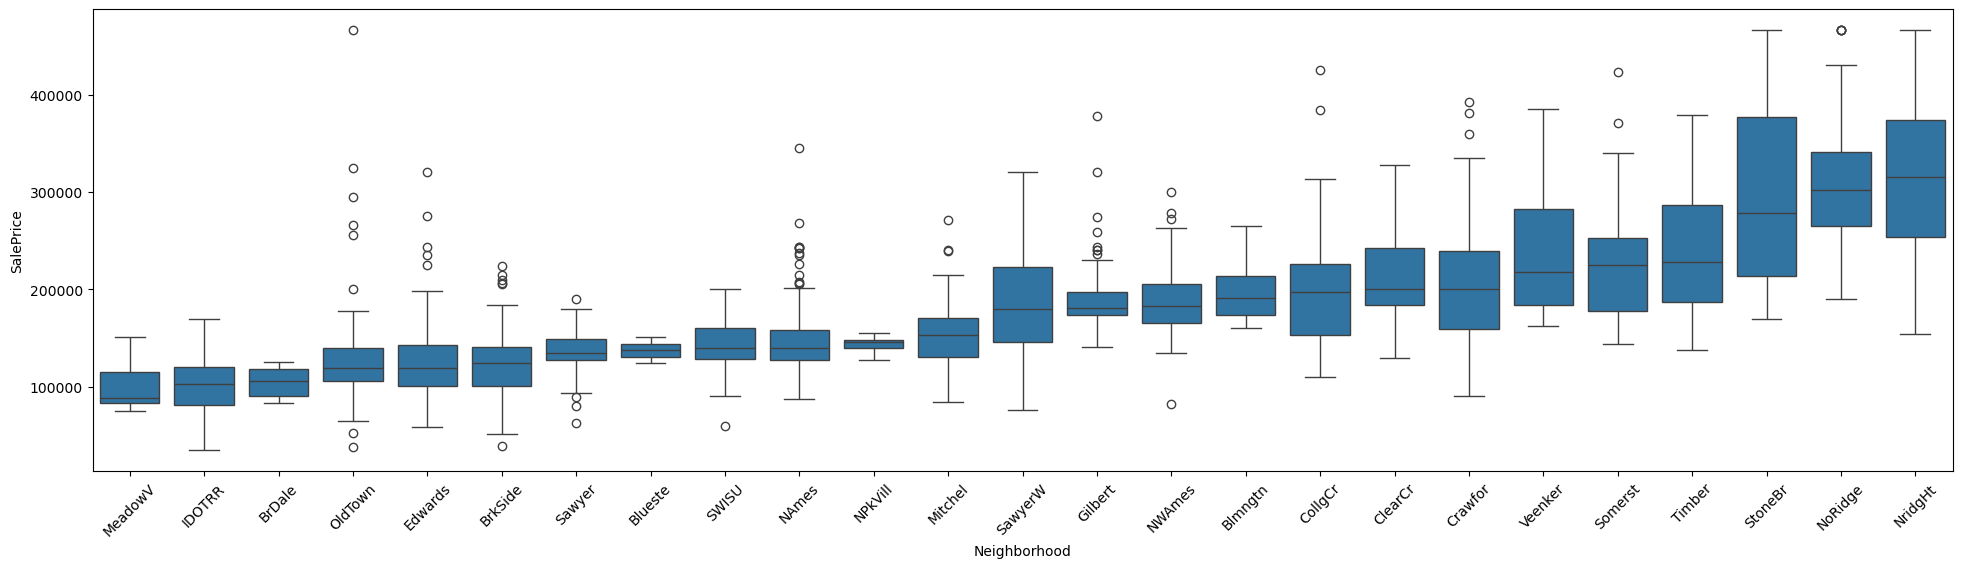

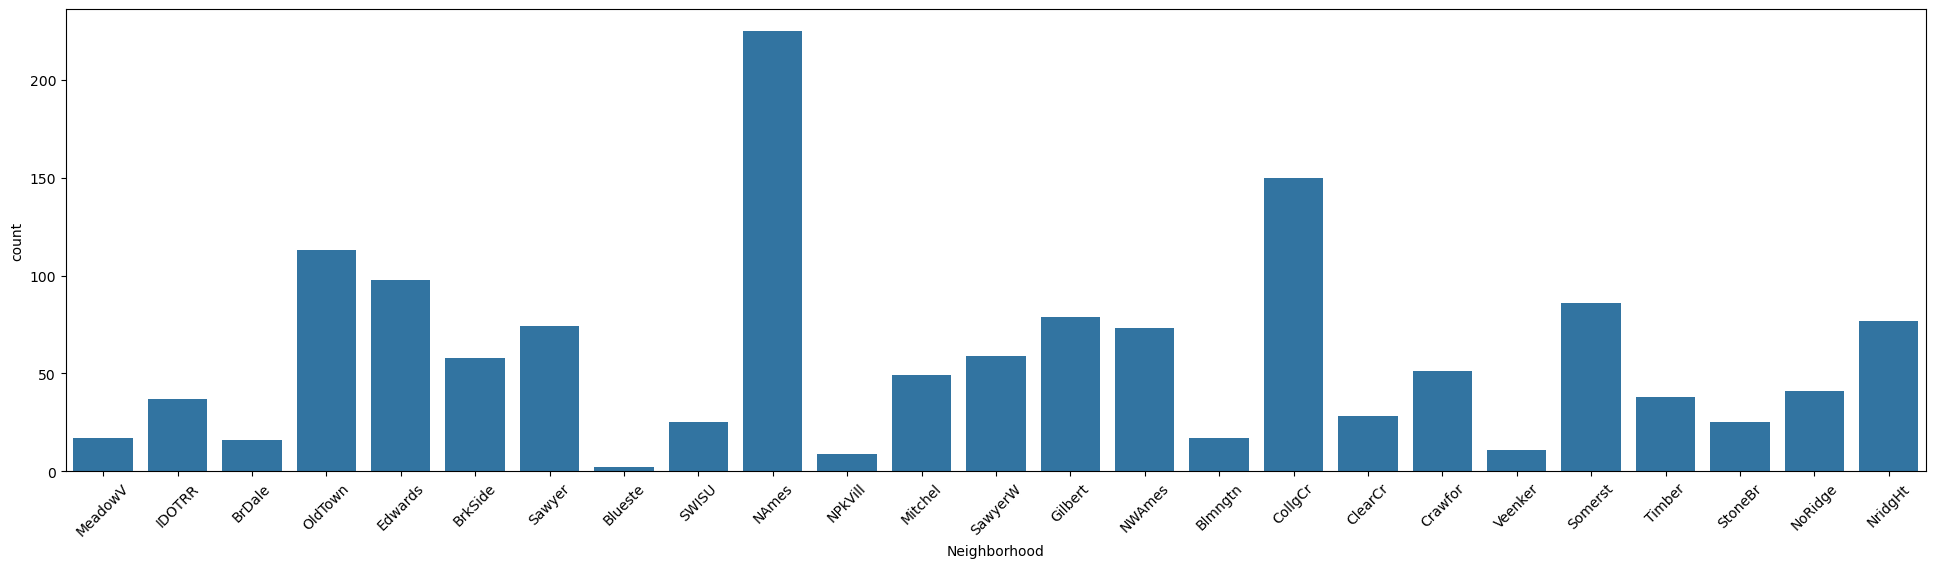

In [85]:
plt.figure(figsize = (24, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice',  data = train, order=neighborhood_order)
plt.xticks(rotation=45)

plt.figure(figsize = (24, 6))
sns.countplot(x = 'Neighborhood', data = train, order=neighborhood_order)
plt.xticks(rotation=45)

In [86]:
# @@处理@@
train["SimpleNeighborhood"] = train.Neighborhood.replace({'IDOTRR': 'IDOTRR-BrDale' , 'BrDale': 'IDOTRR-BrDale',
                                                       'Blueste': 'Blueste-SWISU', 'SWISU': 'Blueste-SWISU' ,
                                                       'NPkVill': 'NPkVill-Mitchel', 'Mitchel': 'NPkVill-Mitchel'
                                                        })

In [87]:
anova(train, ['Neighborhood', 'SimpleNeighborhood'], y)

,feature,pval,disparity
SimpleNeighborhood,SimpleNeighborhood,1.725211e-243,187.593052
Neighborhood,Neighborhood,1.019383e-240,185.462820


## 1.2 转换-分类型变量 one-hot编码  

In [88]:
featurego_cat_column = train.select_dtypes(include = object).columns

In [89]:
# @@处理@@
# 通过one-hot编码创建虚拟特性分类值
train_onehot = pd.get_dummies(train[featurego_cat_column], dtype = int)

In [90]:
train_onehot.columns

Index(['MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60',
       ...
       'SimpleNeighborhood_NWAmes', 'SimpleNeighborhood_NoRidge',
       'SimpleNeighborhood_NridgHt', 'SimpleNeighborhood_OldTown',
       'SimpleNeighborhood_Sawyer', 'SimpleNeighborhood_SawyerW',
       'SimpleNeighborhood_Somerst', 'SimpleNeighborhood_StoneBr',
       'SimpleNeighborhood_Timber', 'SimpleNeighborhood_Veenker'],
      dtype='object', length=476)

# 2 连续型变量

In [91]:
train_ana.loc[train_ana.feature_type != 'object', ].sort_values('conti_corr', ascending = False)

,feature_type,cate_cnt,conti_corr,cate_corr
SalePrice,float64,651,1.000000,NaN
OverallQual,int64,9,0.813136,NaN
GrLivArea,float64,858,0.729925,NaN
ExterQual,int64,4,0.702013,NaN
KitchenQual,int64,4,0.676323,NaN
GarageCars,int64,5,0.658854,NaN
TotalBsmtSF,float64,717,0.657415,NaN
GarageArea,float64,439,0.646848,NaN
1stFlrSF,int64,751,0.635236,NaN
FullBath,int64,4,0.568556,NaN


到这里能看到train里面有一些和SalePrice不相关的数据是没去掉的

## 2.1 衍生-连续型变量 非线性衍生

In [92]:
# @@处理@@
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])

In [93]:
# 检查这种衍生是否提高了相关性
train[['SalePrice', 'OverallQual', 'OverallQual-s2', 'OverallQual-s3', 'OverallQual-Sq',
      'GrLivArea', 'GrLivArea-2', 'GrLivArea-3', 'GrLivArea-Sq']].corr()['SalePrice']

SalePrice         1.000000
OverallQual       0.813136
OverallQual-s2    0.836402
OverallQual-s3    0.842116
OverallQual-Sq    0.793298
GrLivArea         0.729925
GrLivArea-2       0.711288
GrLivArea-3       0.661886
GrLivArea-Sq      0.725357
Name: SalePrice, dtype: float64

## 2.2 衍生-连续型变量 简单组合

In [94]:
# @@处理@@
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
                     train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
                      train["3SsnPorch"] + train["ScreenPorch"]

In [95]:
# 同样检验一下组合的变量的相关性，也是有所提高的，生成了更加有效的变量
train[['TotalBath', 'AllSF', 'AllFlrsSF', 'AllPorchSF', 'SalePrice']].corr()['SalePrice']

TotalBath     0.644327
AllSF         0.829272
AllFlrsSF     0.738871
AllPorchSF    0.355190
SalePrice     1.000000
Name: SalePrice, dtype: float64

## 2.3 转换-连续型变量 正态转换

### 2.3.1 y值正态变换

<Axes: xlabel='SalePrice', ylabel='Density'>

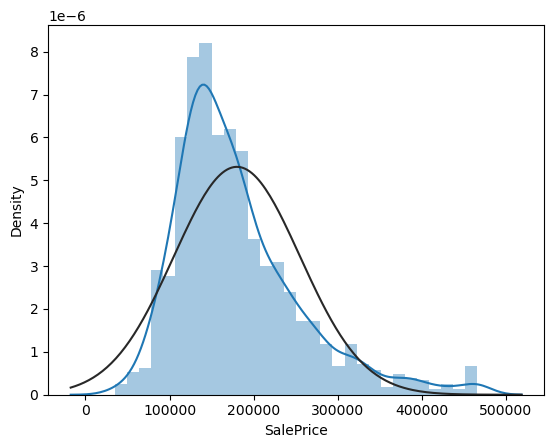

In [96]:
# 分布
sns.distplot(train['SalePrice'], fit=norm) # 新方法 这里为了直观沿用老的方法↓
# ax = sns.histplot(
#     train['SalePrice'],  
#     kde=True,            
#     stat='density',      
#     linewidth=0          
# )

# mu, sigma = norm.fit(train['SalePrice']) # 拟合数据，得到正态分布的均值(mu)和标准差(sigma)
# x = np.linspace(train['SalePrice'].min(), train['SalePrice'].max(), 100)
# y = norm.pdf(x, mu, sigma)

# ax.plot(x, y, 'r--', linewidth=2, label=f'Normal fit: $\mu={mu:.2f}, \sigma={sigma:.2f}$')

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900.,  35311.,  37900., ..., 466075., 466075., 466075.])),
 (71590.14910782737, 180038.12620027436, 0.9516642996431472))

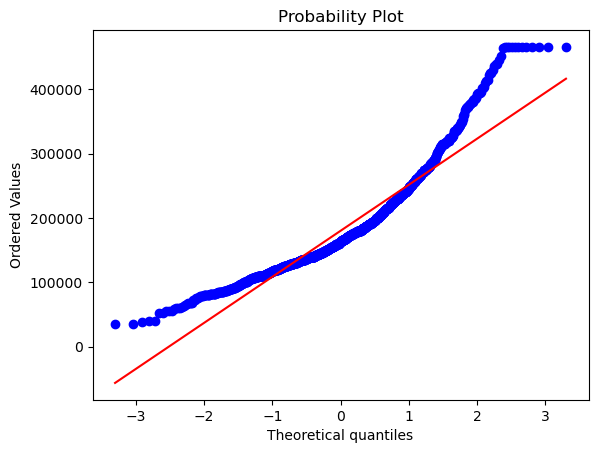

In [97]:
# 利用Q-Q图判断数据是否偏离正态分布
stats.probplot(train['SalePrice'], plot=plt)

In [98]:
train['SalePrice_log'] = np.log1p(train['SalePrice'])

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.05210399,
         13.05210399, 13.05210399])),
 (0.39379532205845363, 12.022389935616642, 0.9956790815015761))

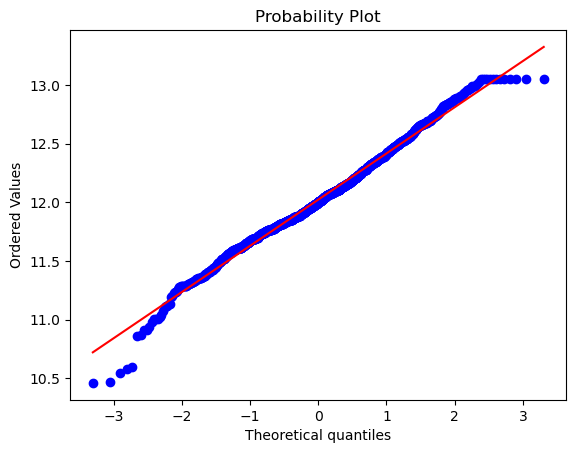

In [99]:
# 利用Q-Q图判断数据是否偏离正态分布
stats.probplot(train['SalePrice_log'], plot=plt)

In [100]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
train[numeric_cols].corr().sort_values('SalePrice_log', ascending=False)[['SalePrice', 'SalePrice_log']] # 计算log变换的y和自变量的相关性

,SalePrice,SalePrice_log
SalePrice_log,0.959597,1.000000
SalePrice,1.000000,0.959597
OverallQual,0.813136,0.820833
AllSF,0.829272,0.816922
OverallQual-s2,0.836402,0.816167
OverallQual-Sq,0.793298,0.816112
OverallQual-s3,0.842116,0.797418
GrLivArea-Sq,0.725357,0.732267
AllFlrsSF,0.738871,0.728168
GrLivArea,0.729925,0.719934


### 2.3.2 连续型特征正态变换

In [101]:
# 对数值特性进行变换，来减少倾斜异常值的影响
#一般的经验法则,绝对偏态值> 0.75被认为是倾斜严重
train_num = train.select_dtypes(include = [np.number]).drop(['SalePrice', 'SalePrice_log'], axis = 1)
skewness = train_num.apply(lambda x: skew(x.dropna())) # 对每一列去掉空值然后计算偏度
skewness = skewness[abs(skewness) > 0.75]
skewness
featurego_skewed_features = skewness.index

LotArea           0.976595
LotShape         -1.107603
OverallCond       0.981738
MasVnrArea        1.811447
ExterQual         0.819203
BsmtExposure      1.219227
BsmtFinSF1        0.764002
BsmtUnfSF         0.919955
1stFlrSF          0.850490
2ndFlrSF          0.812121
GrLivArea         0.900505
WoodDeckSF        1.452533
OpenPorchSF       1.685472
OverallQual-s2    0.847123
OverallQual-s3    1.444201
GrLivArea-2       2.085821
GrLivArea-3       3.592374
AllFlrsSF         0.949012
AllPorchSF        1.685472
dtype: float64

In [102]:
# @@处理@@
train[featurego_skewed_features] = np.log1p(train[featurego_skewed_features])

## 2.4 转换-连续型变量 无量纲化转换

In [103]:
# 使用MinMaxScaler来无量纲转换
from sklearn.preprocessing import MinMaxScaler
train_num = train.select_dtypes(include=[np.number]).drop(['SalePrice', 'SalePrice_log'], axis=1)
featurego_min_max_scaler = MinMaxScaler()
train_num_minmax_array = featurego_min_max_scaler.fit_transform(train_num)

In [ ]:
# featurego_scaler_numcolumn = train_num.columns
# @@处理@@
# train_num_minmax = np.round(featurego_min_max_scaler.transform(train[featurego_scaler_numcolumn]), 2)
# train_num_minmax= pd.DataFrame(train_num_minmax, columns=featurego_scaler_numcolumn + '_minmax', index=train.index)
train_num_minmax = pd.DataFrame(
    np.round(train_num_minmax_array, 2),
    columns = [col + '_minmax' for col in train_num.columns],
    index = train.index
)

## 整合处理

In [105]:
# @@处理@@
train = pd.concat([train, train_onehot, train_num_minmax], axis=1)

In [106]:
# @@处理@@
train.drop(['SalePrice'], axis=1, inplace=True)

In [107]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OverallQual-s2_minmax,OverallQual-s3_minmax,OverallQual-Sq_minmax,GrLivArea-2_minmax,GrLivArea-3_minmax,GrLivArea-Sq_minmax,TotalBath_minmax,AllSF_minmax,AllFlrsSF_minmax,AllPorchSF_minmax
0,1,60,RL,65.0,9.042040,2,1.609438,Lvl,4,Inside,...,0.77,0.77,0.70,0.68,0.68,0.54,0.5,0.38,0.63,0.74
1,2,20,RL,80.0,9.169623,2,1.609438,Lvl,4,FR2,...,0.67,0.68,0.59,0.55,0.55,0.40,0.2,0.37,0.51,0.00
2,3,60,RL,68.0,9.328212,2,1.386294,Lvl,4,Inside,...,0.77,0.77,0.70,0.70,0.70,0.56,0.5,0.40,0.65,0.67
3,4,70,RL,60.0,9.164401,2,1.386294,Lvl,4,Corner,...,0.77,0.77,0.70,0.68,0.68,0.54,0.2,0.36,0.63,0.64
4,5,60,RL,84.0,9.565284,2,1.386294,Lvl,4,FR2,...,0.85,0.86,0.81,0.78,0.78,0.67,0.5,0.51,0.73,0.79
